

### The objective is to create a predictive model that accurately estimates the crop yield per acre for rice or wheat crops in India. The model will assist smallholder farmers in making informed decisions regarding planting, resource allocation, and adaptive farming practices to break the cycle of poverty and malnutrition.

For this project we will use supervised learning techniques since we already know our target "rop yield per acre" and we will use some regressions since the target is a continuous data


### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from vecstack import stacking
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.ensemble import IsolationForest


### Creating a Wrangle Function
This Function embodies data cleaning, preprocessing, and encoding
This function was modified progressively after observing the data set.
The following were achieved in this function;
- Reading the csv file as a dataframe
- Dropping columns with morethan 50% of null values 
- Changing columns that had dates to datetime types inorder to find the number od days between when a seed was planted and it was harvested.
- All other categorical features were encoded into integer data types by using the Label Encoder
- Null values were filled with the median of each column.
- Outliers were removed by removing the values that do not lie between the 0.01 to 0.85 range
- All other missing values will certainly not be from a numerical value and so they were filled with 0
- Columns with multi linear colinearity were dropped 
- and finally the function returns a clean csv file called df

In [46]:
#writing a function that reads csv file ceans it and returns a clean file
def wrangle(file):
    df = pd.read_csv(file)
    
#     Drop columns that have more 50% of nullvalues
    perc = 60
    min_null = int(((100-perc)/100)*df.shape[0] + 1)
    df.dropna(axis=1, thresh=min_null, inplace= True)
    
#   Now we are going to convert the date columns to datetime datatypes inorder to find the difference between the time a seed was planted and the time the crop was harvested in terms of days, so that we can see how the number of days between the planting and harvesting affects the yield of the crops.    
    df['RcNursEstDate'] = pd.to_datetime(df['RcNursEstDate'])
    df['Harv_date'] = pd.to_datetime(df['Harv_date'])
    
#  Finding the number of days between the day a seed was planted and harvested 
    df['NumberOfDaysforHarv'] = (df['Harv_date']-df['RcNursEstDate']).dt.days
    
# Encoding categorical features
    le = LabelEncoder()
    cat = df.loc[:, df.columns != 'ID']
    categories = cat.select_dtypes('object').columns
# categories
    for feat in categories:
#     if feat != 'ID' :
         df[feat] = le.fit_transform(df[feat].astype(str))
    
       # fillna into all missing values
#     categorical_columns = df.select_dtypes(include='object').columns
#     for column in categorical_columns:
#         if column in categorical_columns:
#             df[column].fillna(0, inplace=True)   
    
#     Filling null values with the median of the columns and dropping outliers
    numeric_columns = df.select_dtypes(include=np.number).columns
    for col in numeric_columns:
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
            m = df[col].median()
            df[col].fillna(m, inplace=True)
#             # Calculate the IQR and bounds           
#             low, high = df[col].quantile([0.01, 0.85])
#             mask_area = df[col].between(low, high)
#             df = df[mask_area]
#         else:
#             df[col]=df[col]
    
    isof = IsolationForest(contamination= 0.5, random_state=42)
    df_num = df[numeric_columns]
    outlier_labels = isof.fit_predict(df_num)
    df_num['Outlier'] = outlier_labels
    outliers = df_num[df_num['Outlier'] == -1]
    df_num['Outlier'].replace(-1, np.nan, inplace = True)
    df_num.dropna(subset=['Outlier'], inplace=True)
    df_fin = df_num.drop('Outlier', axis = 1) 
    df_fin['ID'] = df['ID']
   
#     Redoing the Isolation Forest
    num_columns = df_fin.select_dtypes(include=np.number).columns
    isof = IsolationForest(contamination= 0.5, random_state=42)
    df_new = df_fin[num_columns]
    outlier_labels = isof.fit_predict(df_new)
    df_new['Outlier'] = outlier_labels
    outliers = df_new[df_new['Outlier'] == -1]
    df_new['Outlier'].replace(-1, np.nan, inplace = True)
    df_new.dropna(subset=['Outlier'], inplace=True)
    df_final = df_new.drop('Outlier', axis = 1) 
    df_final['ID'] = df_fin['ID']
#  Redoing the Isolation Forest for the thrid time 

    num_column = df_final.select_dtypes(include=np.number).columns
    isof = IsolationForest(contamination= 0.5, random_state=42)
    df_new1 = df_final[num_column]
    outlier_labels = isof.fit_predict(df_new1)
    df_new1['Outlier'] = outlier_labels
    outliers = df_new1[df_new1['Outlier'] == -1]
    df_new1['Outlier'].replace(-1, np.nan, inplace = True)
    df_new1.dropna(subset=['Outlier'], inplace=True)
    df_fin1 = df_new1.drop('Outlier', axis = 1) 
    df_fin1['ID'] = df_final['ID']
# #drop columns with multicolinearity
    df_fin1.drop(columns = ['CultLand','BasalDAP','BasalUrea', 'Residue_perc', 'TransplantingIrrigationPowerSource','MineralFertAppMethod.1', 'OrgFertilizers', 'MineralFertAppMethod', 'Threshing_method'], inplace =True)
    

    return df_fin1
df = wrangle('Train.csv')

df.info() 



C:\Users\vtebo\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\vtebo\AppData\Local\Temp\ipykernel_2948\2383902309.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num['Outlier'] = outlier_labels
C:\Users\vtebo\AppData\Local\Temp\ipykernel_2948\2383902309.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num['Outlier'].replace(-1, np.nan, inplace = True)
C:\Users\vtebo\AppData\Local\Temp\ipykernel_2948\2383902309.py:51: Settin

<class 'pandas.core.frame.DataFrame'>
Int64Index: 484 entries, 14 to 3863
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   District                       484 non-null    int32  
 1   Block                          484 non-null    int32  
 2   CropCultLand                   484 non-null    int64  
 3   LandPreparationMethod          484 non-null    int32  
 4   CropTillageDate                484 non-null    int32  
 5   CropTillageDepth               484 non-null    int64  
 6   CropEstMethod                  484 non-null    int32  
 7   SeedingSowingTransplanting     484 non-null    int32  
 8   SeedlingsPerPit                484 non-null    float64
 9   NursDetFactor                  484 non-null    int32  
 10  TransDetFactor                 484 non-null    int32  
 11  TransplantingIrrigationHours   484 non-null    float64
 12  TransplantingIrrigationSource  484 non-null    i

C:\Users\vtebo\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [32]:
variable_des = pd.read_csv('VariableDescription.csv')
variable_des

,Variable,Description
0,District,Name of the district
1,Block,Name of the block
2,CultLand,Area of total cultivated land
3,CropCultLand,Area of land under cultivation
4,LandPreparationMethod,Method for land preparation
5,CropTillageDate,Date of tillage of the largest plot
6,CropTillageDepth,Depth of the tillage
7,CropEstMethod,Method of transplantation
8,RcNursEstDate,Date of nursery establishment
9,SeedingSowingTransplanting,Crop establishment method - sowing/transplanting


### checking for outliers using the describe function, zcsore function and visualisation 

In [47]:
df.describe()

,District,Block,CropCultLand,LandPreparationMethod,CropTillageDate,CropTillageDepth,CropEstMethod,SeedingSowingTransplanting,SeedlingsPerPit,NursDetFactor,...,1tdUrea,1appDaysUrea,Harv_method,Harv_hand_rent,Threshing_date,Residue_length,Stubble_use,Acre,Yield,NumberOfDaysforHarv
count,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.0,484.000000,484.000000,484.000000,...,484.000000,484.000000,484.0,484.000000,484.000000,484.000000,484.0,484.000000,484.000000,484.000000
mean,1.380165,4.452479,16.991736,24.336777,36.489669,4.657025,3.0,24.776860,2.485537,13.128099,...,8.886364,25.421488,0.0,338.280992,82.121901,27.859504,1.0,0.218365,410.268595,141.904959
std,1.145745,2.075145,10.175476,9.683619,13.508141,1.060359,0.0,14.196484,1.220001,15.922695,...,3.674305,10.960310,0.0,240.575233,39.612037,2.153742,0.0,0.080578,206.633316,15.192187
min,0.000000,0.000000,2.000000,6.000000,5.000000,1.000000,3.0,0.000000,1.000000,0.000000,...,2.000000,4.000000,0.0,3.000000,16.000000,23.000000,1.0,0.074074,4.000000,105.000000
25%,0.000000,3.000000,10.000000,18.000000,25.000000,4.000000,3.0,16.000000,2.000000,1.000000,...,6.000000,20.000000,0.0,120.000000,44.000000,26.000000,1.0,0.181818,320.000000,128.750000
50%,1.000000,5.000000,15.000000,18.000000,37.000000,4.000000,3.0,22.000000,2.000000,4.000000,...,9.000000,25.000000,0.0,300.000000,77.000000,28.000000,1.0,0.227273,400.000000,144.500000
75%,2.000000,7.000000,25.000000,33.000000,49.000000,5.000000,3.0,31.000000,3.000000,24.000000,...,10.000000,31.000000,0.0,425.000000,114.250000,30.000000,1.0,0.250000,490.500000,154.000000
max,3.000000,8.000000,50.000000,41.000000,59.000000,8.000000,3.0,59.000000,9.000000,92.000000,...,24.000000,75.000000,0.0,1200.000000,158.000000,30.000000,1.0,0.370370,860.000000,181.000000


In [34]:
# Iterate through each column in the dataset
from scipy.stats import zscore
def outliers(path):
#     train=pd.read_csv(path)
    for column in path.columns:
        # Check if the column contains numerical data
        if np.issubdtype(path[column].dtype, np.number):
            # Calculate the Z-scores of the column
            z_scores = zscore(path[column])

            # Identify the outliers based on a threshold
            outliers = path[abs(z_scores) > 3]  # Adjust the threshold as required

            # Print column name and outlier count
            return print(f"Column '{column}' has {len(outliers)} outliers.\n")


### Verifying if there are outliers

In [35]:
outliers(df)

Column 'District' has 0 outliers.



C:\Users\vtebo\AppData\Local\Temp\ipykernel_2948\2612950340.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


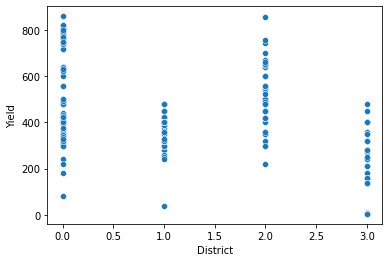

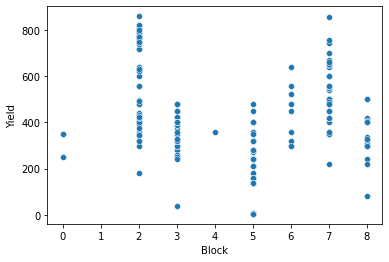

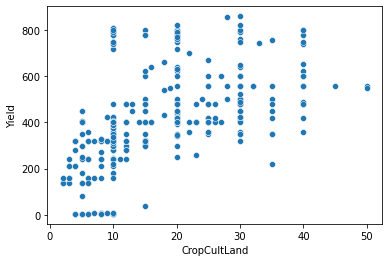

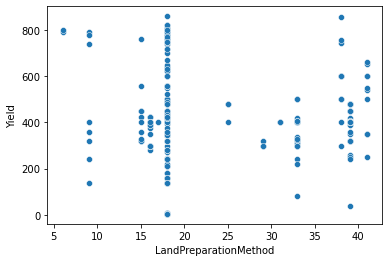

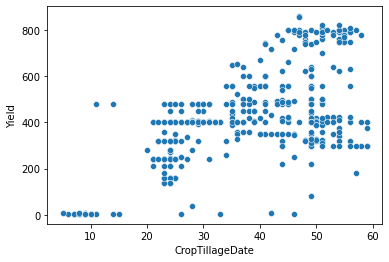

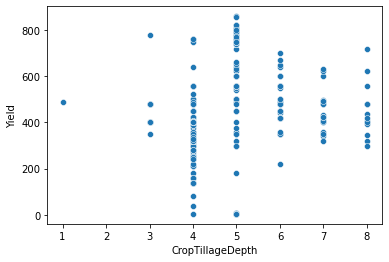

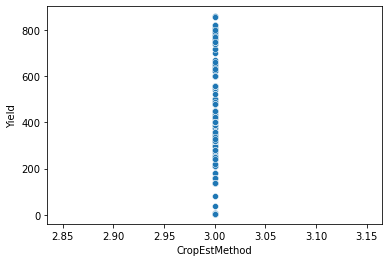

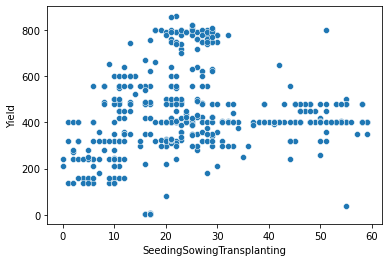

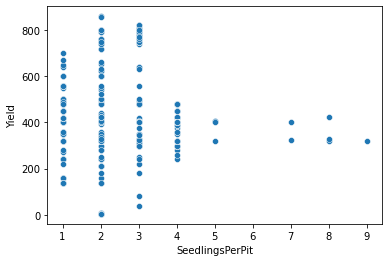

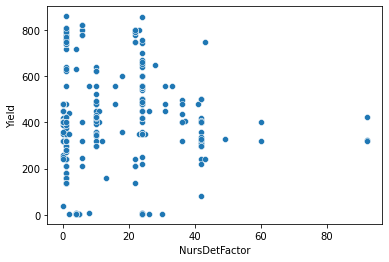

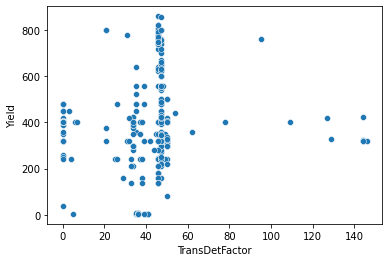

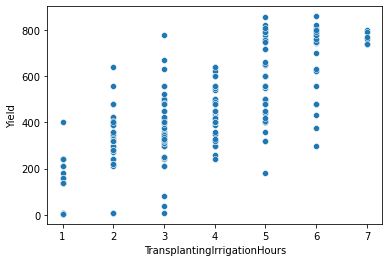

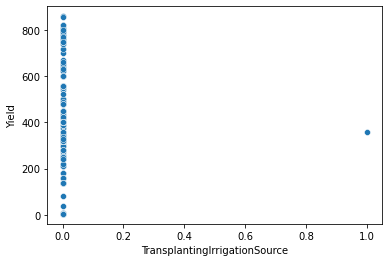

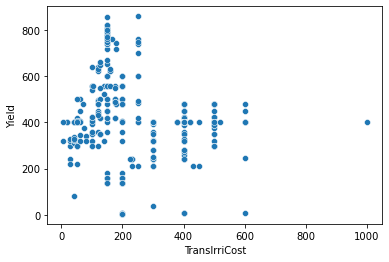

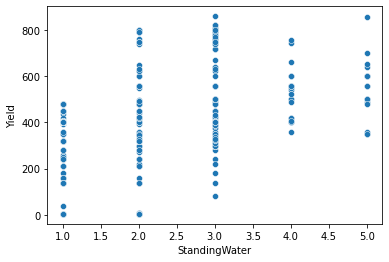

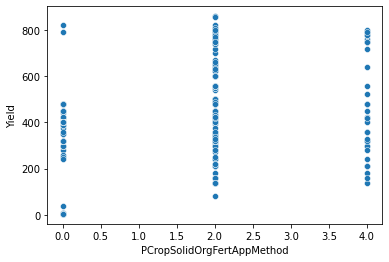

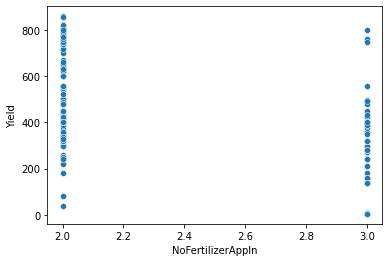

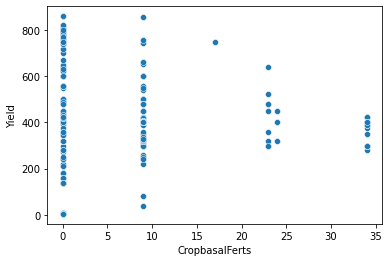

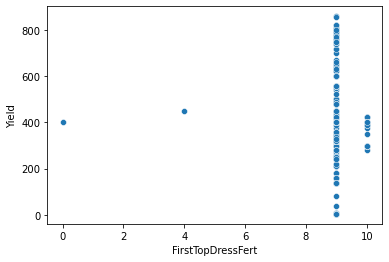

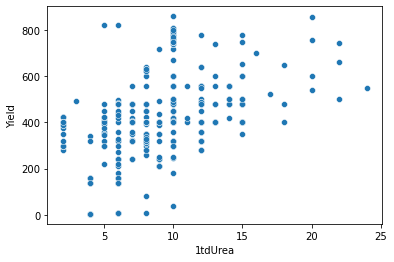

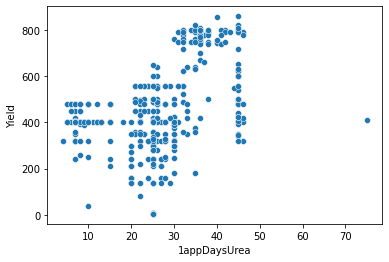

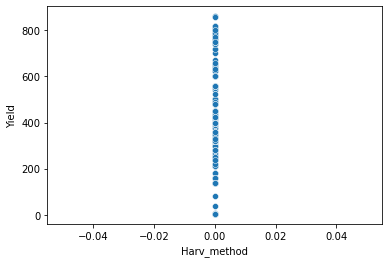

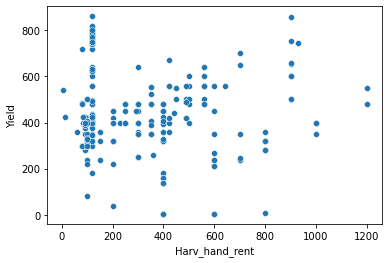

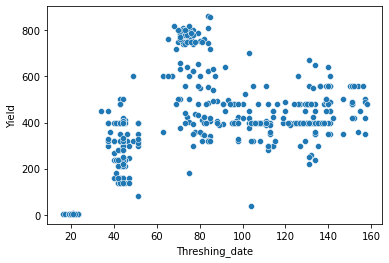

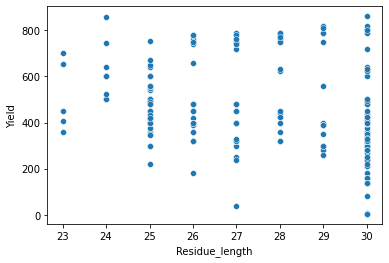

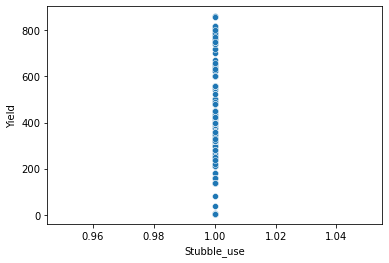

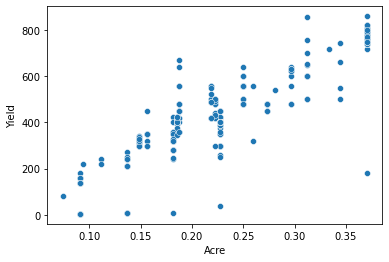

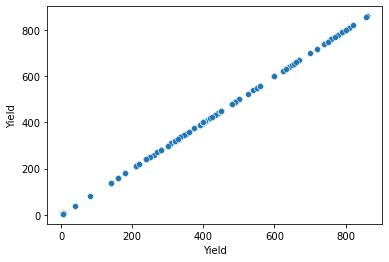

<Figure size 432x288 with 0 Axes>

In [48]:
numeric_data = list(df._get_numeric_data())
for i in range(len(numeric_data)-1):   
    sns.scatterplot(x=numeric_data[i],y='Yield', data=df, palette='winter')
    plt.figure()




In [37]:
# categorical_data = df.drop(columns='ID').select_dtypes(include='object').columns
# for i in categorical_data:    
#     sns.barplot(x= i,y='Yield', data=df, palette='winter')
#     plt.figure(figsize=(12,10))

In [38]:
corr = df.corr()
corr

,District,Block,CropCultLand,LandPreparationMethod,CropTillageDate,CropTillageDepth,CropEstMethod,SeedingSowingTransplanting,SeedlingsPerPit,NursDetFactor,...,1tdUrea,1appDaysUrea,Harv_method,Harv_hand_rent,Threshing_date,Residue_length,Stubble_use,Acre,Yield,NumberOfDaysforHarv
District,1.000000,0.269081,-0.076179,-0.126156,-0.481448,-0.159813,0.023052,-0.454793,-0.328403,-0.245900,...,0.199102,-0.106728,NaN,0.392683,-0.223935,-0.005601,NaN,-0.256802,-0.278692,0.166379
Block,0.269081,1.000000,0.302736,0.159791,-0.243633,-0.037341,-0.005970,-0.503169,-0.387600,0.225288,...,0.247415,0.054750,NaN,0.193683,-0.189431,-0.275049,NaN,-0.188173,-0.065498,0.006619
CropCultLand,-0.076179,0.302736,1.000000,0.121571,0.094748,0.330170,-0.038450,-0.069971,-0.252975,-0.070572,...,0.413855,0.254773,NaN,0.121109,0.335479,-0.453404,NaN,0.412876,0.453993,0.213625
LandPreparationMethod,-0.126156,0.159791,0.121571,1.000000,-0.049036,-0.235763,0.037052,0.312491,0.026457,-0.069413,...,0.317049,-0.149909,NaN,0.081744,0.109045,-0.102016,NaN,0.088675,0.057461,-0.351396
CropTillageDate,-0.481448,-0.243633,0.094748,-0.049036,1.000000,-0.006216,-0.078318,0.280129,0.317092,0.263391,...,0.087389,0.345357,NaN,-0.157485,0.329158,-0.038870,NaN,0.384598,0.398577,0.110004
CropTillageDepth,-0.159813,-0.037341,0.330170,-0.235763,-0.006216,1.000000,-0.010831,-0.162325,-0.238708,-0.042933,...,-0.090255,0.381421,NaN,-0.030244,0.039263,-0.115953,NaN,0.052639,0.102888,0.290665
CropEstMethod,0.023052,-0.005970,-0.038450,0.037052,-0.078318,-0.010831,1.000000,0.005300,0.078413,-0.102814,...,-0.011410,-0.063121,NaN,-0.080637,0.022807,0.118231,NaN,-0.131268,-0.143515,-0.047370
SeedingSowingTransplanting,-0.454793,-0.503169,-0.069971,0.312491,0.280129,-0.162325,0.005300,1.000000,0.397097,-0.035937,...,-0.100822,-0.335895,NaN,-0.252834,0.445913,-0.050237,NaN,0.181963,0.092997,-0.374914
SeedlingsPerPit,-0.328403,-0.387600,-0.252975,0.026457,0.317092,-0.238708,0.078413,0.397097,1.000000,0.335672,...,-0.122608,-0.120755,NaN,-0.167586,0.166145,0.065520,NaN,-0.020552,-0.107779,-0.203265
NursDetFactor,-0.245900,0.225288,-0.070572,-0.069413,0.263391,-0.042933,-0.102814,-0.035937,0.335672,1.000000,...,-0.096359,0.153561,NaN,0.060852,-0.083624,-0.243127,NaN,-0.107968,-0.001240,-0.070826


### Checking For Multicolinearity

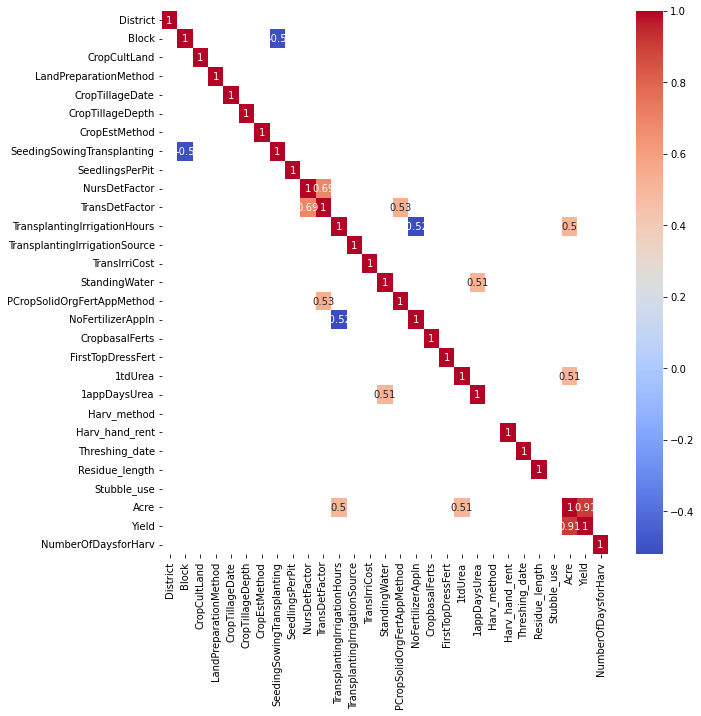

In [39]:
plt.figure(figsize=(10,10))
correlation_matrix = corr.abs()>0.5
sns.heatmap(corr[correlation_matrix], annot=True, cmap='coolwarm')
plt.show()

In [40]:
corr[correlation_matrix]

,District,Block,CropCultLand,LandPreparationMethod,CropTillageDate,CropTillageDepth,CropEstMethod,SeedingSowingTransplanting,SeedlingsPerPit,NursDetFactor,...,1tdUrea,1appDaysUrea,Harv_method,Harv_hand_rent,Threshing_date,Residue_length,Stubble_use,Acre,Yield,NumberOfDaysforHarv
District,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Block,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,-0.503169,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CropCultLand,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LandPreparationMethod,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CropTillageDate,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CropTillageDepth,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CropEstMethod,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeedingSowingTransplanting,NaN,-0.503169,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeedlingsPerPit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NursDetFactor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Training the model

#### Using the Random Forest Tree Rgressor

In [49]:
# split the data set
X = df.drop(columns=['Yield', 'ID'])
X =X.select_dtypes(include=np.number)
y = df['Yield']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20, random_state= 1234)

# Instantiate model
model = RandomForestRegressor(random_state = 1234)

# Fit model
model = model.fit(X_train, y_train)

# Make predictions
pred1 = model.predict(X_test)

# Measure model performance
mean_squared_error(y_test, pred1)


5627.686058762886

In [50]:
mean_absolute_error(y_test, pred1)


31.38319587628866

#### Training using Logistic Rgression by scaling the data frame and using  piple to model the dataframe

In [54]:
# split the data set
X = df.drop(columns=['Yield', "ID"])
X =X.select_dtypes(include=np.number)
y = df['Yield']

X_train, X_test, y_train, y_test = train_test_split(X.fillna(0), y, test_size= 0.25, random_state= 1234)

# Creating a pipeline to easily model and scale our dataset simultaneously
pipe = make_pipeline(StandardScaler(), LogisticRegression())

pipe.fit(X_train.fillna(0), y_train)
pred2 = pipe.predict(X_test)
# Pipeline(steps=[('standardscaler', StandardScaler()),
#                 ('logisticregression', LogisticRegression())])

# pipe.score(X_test, pred4)
mean_squared_error(y_test, pred2)

C:\Users\vtebo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


20302.456611570247

#### Using the GradientBoosting Regressor

In [55]:
# split the data set
X = df.drop(columns=['Yield', "ID"])
X =X.select_dtypes(include=np.number)
y = df['Yield']

X_train, X_test, y_train, y_test = train_test_split(X.fillna(0), y, test_size= 0.25, random_state= 42)

# Instantiate model
Gb_model = GradientBoostingRegressor(random_state=40)

# Fit model
Gb_model.fit(X_train, y_train)

# Make predictions
pred3 = Gb_model.predict(X_test)

# Measure model performance
rmse1 = mean_squared_error(y_test, pred3)
mae2 = mean_absolute_error(y_test, pred3)

In [56]:
rmse1

37483.64370852589

In [17]:
mae2

24.978088437257743

#### Using the Support Vector Regressor, Using the grid search to find the best grid hyperparameters that yields a model with the least mean square error

In [18]:
# split the data set
X = df.drop(columns=['Yield', "ID"])
X =X.select_dtypes(include=np.number)
y = df['Yield']

X_train, X_test, y_train, y_test = train_test_split(X.fillna(0), y, test_size= 0.20, random_state= 1234)

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVR(), param_grid, refit = True, verbose = 4)
  
# fitting the model for grid search
grid = grid.fit(X_train, y_train)
pred4 = grid.predict(X_test)
rmse2 = mean_squared_error(y_test, pred4)
mae3 = mean_absolute_error(y_test, pred4)
# df['Yield']
print(rmse2)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.051 total time=   0.0s
[CV 2/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.002 total time=   0.0s
[CV 3/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.045 total time=   0.0s
[CV 4/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.032 total time=   0.0s
[CV 5/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.000 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.1, kernel=rbf;, score=-0.050 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.1, kernel=rbf;, score=-0.001 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=0.1, kernel=rbf;, score=-0.045 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=0.1, kernel=rbf;, score=-0.032 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.000 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=0.01, kernel=rbf;, score=-0.049 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 2/5] END ......C=1000, gamma=1, kernel=rbf;, score=-0.006 total time=   0.0s
[CV 3/5] END ......C=1000, gamma=1, kernel=rbf;, score=-0.003 total time=   0.0s
[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.001 total time=   0.0s
[CV 5/5] END ......C=1000, gamma=1, kernel=rbf;, score=-0.003 total time=   0.0s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.114 total time=   0.0s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.183 total time=   0.0s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.107 total time=   0.0s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.197 total time=   0.0s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.203 total time=   0.0s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.384 total time=   0.0s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.358 total time=   0.0s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.370 total time=   0.0s
[CV 4/5] END ....C=1000, gam

### Using the ensemble on the three models trained above. 
Ensemble learning is a general meta approach to machine learning that seeks better predictive performance by combining the predictions from multiple models.

#### Using the Agaboost model to train the model:
Agaboost is a an ensemble that combines weak leaners which are generally stumps to make classifications, the errors gotten from these classifications influence the net classification by making some stumps more highlighted than others.

In [55]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn import model_selection
from sklearn.model_selection import KFold
# from sklearn.model_selection import RandomizedSearchCV


#Collecting just the values from our data frame and splitting 
# split the data set
X = df.drop(columns=['Yield', "ID"])
X_aga =X.select_dtypes(include=np.number).values
y_aga = df['Yield'].values
X_train, X_test, y_train, y_test = train_test_split(X_aga, y_aga, test_size= 0.25, random_state=7)

num_trees = 25
#Grid search for adaboost optimisation
param_dist = {
 'n_estimators': [50, 100],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
 'loss' : ['linear', 'square', 'exponential']
 }

# define the model with default hyperparameters
model = AdaBoostRegressor()

# define the evaluation procedure
cv = KFold(n_splits=5, shuffle=True, random_state=7)

# define the grid search procedure
grid_search = GridSearchCV(model, param_dist, cv = cv,  refit = True, verbose = 3)

aga_model = grid_search.fit(X_train, y_train)
pred5 = aga_model.predict(X_test)
#results = model_selection.cross_val_score(aga_model, X,Y, cv = Kfold)

print(mean_squared_error(y_test, pred5))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END learning_rate=0.01, loss=linear, n_estimators=50;, score=0.878 total time=   0.0s
[CV 2/5] END learning_rate=0.01, loss=linear, n_estimators=50;, score=0.926 total time=   0.0s
[CV 3/5] END learning_rate=0.01, loss=linear, n_estimators=50;, score=0.876 total time=   0.0s
[CV 4/5] END learning_rate=0.01, loss=linear, n_estimators=50;, score=0.976 total time=   0.0s
[CV 5/5] END learning_rate=0.01, loss=linear, n_estimators=50;, score=0.946 total time=   0.0s
[CV 1/5] END learning_rate=0.01, loss=linear, n_estimators=100;, score=0.880 total time=   0.1s
[CV 2/5] END learning_rate=0.01, loss=linear, n_estimators=100;, score=0.928 total time=   0.2s
[CV 3/5] END learning_rate=0.01, loss=linear, n_estimators=100;, score=0.879 total time=   0.1s
[CV 4/5] END learning_rate=0.01, loss=linear, n_estimators=100;, score=0.976 total time=   0.1s
[CV 5/5] END learning_rate=0.01, loss=linear, n_estimators=100;, score=0.947 to

[CV 1/5] END learning_rate=0.1, loss=exponential, n_estimators=100;, score=0.888 total time=   0.1s
[CV 2/5] END learning_rate=0.1, loss=exponential, n_estimators=100;, score=0.918 total time=   0.1s
[CV 3/5] END learning_rate=0.1, loss=exponential, n_estimators=100;, score=0.893 total time=   0.1s
[CV 4/5] END learning_rate=0.1, loss=exponential, n_estimators=100;, score=0.964 total time=   0.1s
[CV 5/5] END learning_rate=0.1, loss=exponential, n_estimators=100;, score=0.922 total time=   0.1s
[CV 1/5] END learning_rate=0.3, loss=linear, n_estimators=50;, score=0.887 total time=   0.0s
[CV 2/5] END learning_rate=0.3, loss=linear, n_estimators=50;, score=0.899 total time=   0.0s
[CV 3/5] END learning_rate=0.3, loss=linear, n_estimators=50;, score=0.899 total time=   0.0s
[CV 4/5] END learning_rate=0.3, loss=linear, n_estimators=50;, score=0.964 total time=   0.0s
[CV 5/5] END learning_rate=0.3, loss=linear, n_estimators=50;, score=0.904 total time=   0.0s
[CV 1/5] END learning_rate=0.3

#### Using the averaging ensemble method
This method finds the average of the individual performance of various models 

In [57]:
# X = df.drop(columns=['Yield', "ID"])
# X =X.select_dtypes(include=np.number)
# y = df['Yield']

# X_train, X_test, y_train, y_test = train_test_split(X.fillna(0), y, test_size= 0.25, random_state= 1234)

# # final prediction after averaging on the prediction of all 3 models
# aver_final = (pred1+pred3+pred5)/3.0
 
# # printing the mean squared error between real value and predicted value
# print(mean_squared_error(y_test, aver_final))

#### Using the stacking ensemble method
Satcking method generally uses a combination of many models and trains a training data, the result creates a matrix whisch is the resulting target for each model, this resulting matrix is again trained this time with a single model of your choosing. This is usually done to improve the performance of a model 

In [58]:
# importing utility modules
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
# import xgboost as xgb
from sklearn.linear_model import LinearRegression

# importing stacking lib
from vecstack import stacking

# initializing all the base model objects with default parameters
model_1 = xgb.XGBRegressor()
model_2 = GradientBoostingRegressor()
model_3 = RandomForestRegressor()

# split the data set
X = df.drop(columns=['Yield', "ID"])
X =X.select_dtypes(include=np.number)
y = df['Yield']
# Creating an np array that excludes the target co;umn which happens to be the 28th
X_stack = X.values
y_stack = y.values

X_train, X_test, y_train, y_test = train_test_split(X_stack, y_stack, test_size= 0.25, random_state= 42)

# putting all base model objects in one list
all_models = [model_1, model_2, model_3]

# computing the stack features
s_train, s_test = stacking(all_models, X_train, y_train, X_test, regression=True, shuffle=True, n_folds=10, random_state= 42)

# initializing the second-level model
final_model = model_3

# fitting the second level model with stack features
model1 = final_model.fit(s_train, y_train)

# predicting the final output using stacking
pred_final = model1.predict(s_test)

# printing the mean squared error between real value and predicted value
print(mean_squared_error(y_test, pred_final))


5557.834673553718


In [59]:
print(mean_absolute_error(y_test, pred_final))

33.86553719008264


In [60]:
from mlxtend.regressor import StackingRegressor

In [61]:
# split the data set
X = df.drop(columns=['Yield', "ID"])
X =X.select_dtypes(include=np.number).values
y = df['Yield'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state= 1234)
model_1 = AdaBoostRegressor()
model_2 = GradientBoostingRegressor()
model_3 = RandomForestRegressor()

# putting all base model objects in one list
all_models = [model_1, model_2, model_3]
clf_stack = StackingRegressor(regressors=all_models, meta_regressor= model_1, use_features_in_secondary = True)

model_stack = clf_stack.fit(X_train, y_train)   # training of stacked model
pred_stack = model_stack.predict(X_test)       # predictions on test data using stacked model

print(mean_squared_error(pred_stack, y_test))

5891.591047318148


#### As we can notice from the above that the Ensemble Agaboost and stacking method are best suited for modeling as they reduce the Mean squared error significantly

### Predicting the values for our test dataset

In [63]:
test = wrangle('Test.csv')
test.head()

C:\Users\vtebo\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\vtebo\AppData\Local\Temp\ipykernel_2948\2383902309.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num['Outlier'] = outlier_labels
C:\Users\vtebo\AppData\Local\Temp\ipykernel_2948\2383902309.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num['Outlier'].replace(-1, np.nan, inplace = True)
C:\Users\vtebo\AppData\Local\Temp\ipykernel_2948\2383902309.py:51: Settin

,District,Block,CropCultLand,LandPreparationMethod,CropTillageDate,CropTillageDepth,CropEstMethod,SeedingSowingTransplanting,SeedlingsPerPit,NursDetFactor,...,1tdUrea,1appDaysUrea,Harv_method,Harv_hand_rent,Threshing_date,Residue_length,Stubble_use,Acre,NumberOfDaysforHarv,ID
12,2,8,30,28,35,5,3,13,2.0,21,...,15.0,45.0,0,900.0,78,25,1,0.312500,169.0,ID_P9K9GAHC6FX6
37,2,8,50,25,52,5,3,25,2.0,21,...,20.0,45.0,0,930.0,77,23,1,0.343750,154.0,ID_9SNP46T1GSJI
42,0,9,20,19,49,4,3,20,2.0,38,...,10.0,25.0,0,100.0,39,30,1,0.185185,122.0,ID_03QW4RBYQEBK
45,2,8,40,9,35,6,3,19,1.0,21,...,14.0,29.0,0,560.0,137,25,1,0.250000,163.0,ID_YB866N9RY5TU
48,3,6,10,9,9,5,3,17,2.0,2,...,10.0,25.0,0,1000.0,16,30,1,0.227273,125.0,ID_4P7NKCB6LMJ5


In [64]:
# Make predictions on the Zindi test set
# X = test.drop(columns=['Yield', "ID"])
X = test.select_dtypes(include=np.number)
test_df = test[X.columns]
preds = model_stack.predict(test_df.fillna(0))

# Create submisiion file to be uploaded to Zindi for scoring
sub = pd.DataFrame({'ID': test.ID, 'Yield': preds})
sub.to_csv('newSubmission1.csv', index = False)

sub.head()

C:\Users\vtebo\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but AdaBoostRegressor was fitted without feature names
  warnings.warn(
C:\Users\vtebo\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\vtebo\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


,ID,Yield
12,ID_P9K9GAHC6FX6,636.836735
37,ID_9SNP46T1GSJI,815.400000
42,ID_03QW4RBYQEBK,392.158416
45,ID_YB866N9RY5TU,507.753846
48,ID_4P7NKCB6LMJ5,359.687500


In [ ]:
# def stacking_model(file):
#     model_1 = xgb.XGBRegressor()
#     model_2 = GradientBoostingRegressor()
#     model_3 = RandomForestRegressor()
#     test['Yield'] = []
#     array = test.values
#     X_stack = array[:, 1:29]
#     y_stack = array [:, 29]

#     X_train, X_test, y_train, y_test = train_test_split(X_stack, y_stack, test_size= 0.25, random_state= 7)

#     # putting all base model objects in one list
#     all_models = [model_1, model_2, model_3]

#     # computing the stack features
#     s_train, s_test = stacking(all_models, X_train, y_train, X_test, regression=True, shuffle=True, n_folds=10)

#     # initializing the second-level model
#     final_model = model_3

#     # fitting the second level model with stack features
#     model1 = final_model.fit(s_train, y_train)
    
#     return model1


In [ ]:
# stacking_model(test)